In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I want to compare career success to personality. I'll be measuring success in three ways - employment status, salary, and satisfaction (which I will take as the average of job satisfaction and career satisfaction). I will use some of the columns with responses ranging from "Strongly disagree" to "Strongly agree" to measure personality.

In [2]:
for i in range(schema.shape[0]):
    print(schema["Column"][i])
    print(schema["Question"][i])
    print('\n')

Respondent
Respondent ID number


Professional
Which of the following best describes you?


ProgramHobby
Do you program as a hobby or contribute to open source projects?


Country
In which country do you currently live?


University
Are you currently enrolled in a formal, degree-granting college or university program?


EmploymentStatus
Which of the following best describes your current employment status?


FormalEducation
Which of the following best describes the highest level of formal education that you've completed?


MajorUndergrad
Which of the following best describes your main field of study (aka 'major') in college or university/for your undergraduate studies?


HomeRemote
How often do you work from home or remotely?


CompanySize
In terms of the number of employees, how large is the company or organization you work for?


CompanyType
Which of the following best describes the type of company or organization you work for?


YearsProgram
How long has it been since you first learn

Other than the first three columns, these are the columns I am considering for the personality metrics.

In [3]:
df2 = df[['EmploymentStatus', 'Salary', 'JobSatisfaction', 'CareerSatisfaction', 'ProblemSolving', 'LearningNewTech', 'BoringDetails', 
   'JobSecurity', 'DiversityImportant', 'AnnoyingUI', 'RightWrongWay', 'SeriousWork', 
   'InvestTimeTools', 'WorkPayCare', 'ChallengeMyself', 'CompetePeers', 'ChangeWorld', 
   'ShipIt', 'OtherPeoplesCode', 'ProjectManagement', 'EnjoyDebugging', 'InTheZone',
   'DifficultCommunication', 'CollaborateRemote']]

The following code shows me the sort of values in each of these columns. EmploymentStatus is a text field. Salary is a continuous numerical field. JobSatisfaction and CareerSatisfaction are discrete numerical fields, taking values from 0 to 10. The other columns all take text values from "Strongly disagree" to "Strongly agree". I could convert these to numerical values, then any machine learning methods used would be aware that these values have an order. However, I'm not using any machine learning methods so it will be good enough to make sure the labels are listed in the correct order when plotting graphs.

In [4]:
for i in df2.columns:
    print(df2[i].unique())

['Not employed, and not looking for work' 'Employed part-time'
 'Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Not employed, but looking for work' 'I prefer not to say' 'Retired']
[            nan 113750.         100000.         ...  28506.78733032
   2972.97297297  50500.        ]
[nan  9.  3.  8.  6.  7.  5.  4. 10.  2.  0.  1.]
[nan  8.  6.  7.  3.  9.  5. 10.  4.  0.  2.  1.]
['Strongly agree' nan 'Agree' 'Somewhat agree' 'Disagree'
 'Strongly disagree']
['Agree' nan 'Strongly agree' 'Somewhat agree' 'Disagree'
 'Strongly disagree']
['Disagree' nan 'Somewhat agree' 'Strongly disagree' 'Strongly agree'
 'Agree']
['Strongly agree' nan 'Agree' 'Somewhat agree' 'Strongly disagree'
 'Disagree']
['Agree' nan 'Strongly agree' 'Somewhat agree' 'Strongly disagree'
 'Disagree']
['Agree' nan 'Strongly agree' 'Somewhat agree' 'Disagree'
 'Strongly disagree']
['Somewhat agree' nan 'Disagree' 'Agree' 'Strongly disagree'
 'Strongly agree']
['Strongly agree' nan 'Ag

I will plot the distribution of responses for each of the columns I am considering as a personality metric. I want to use columns where the answers are more evenly spread, as a better spread of responses will be more useful for finding relationships with the success metrics.

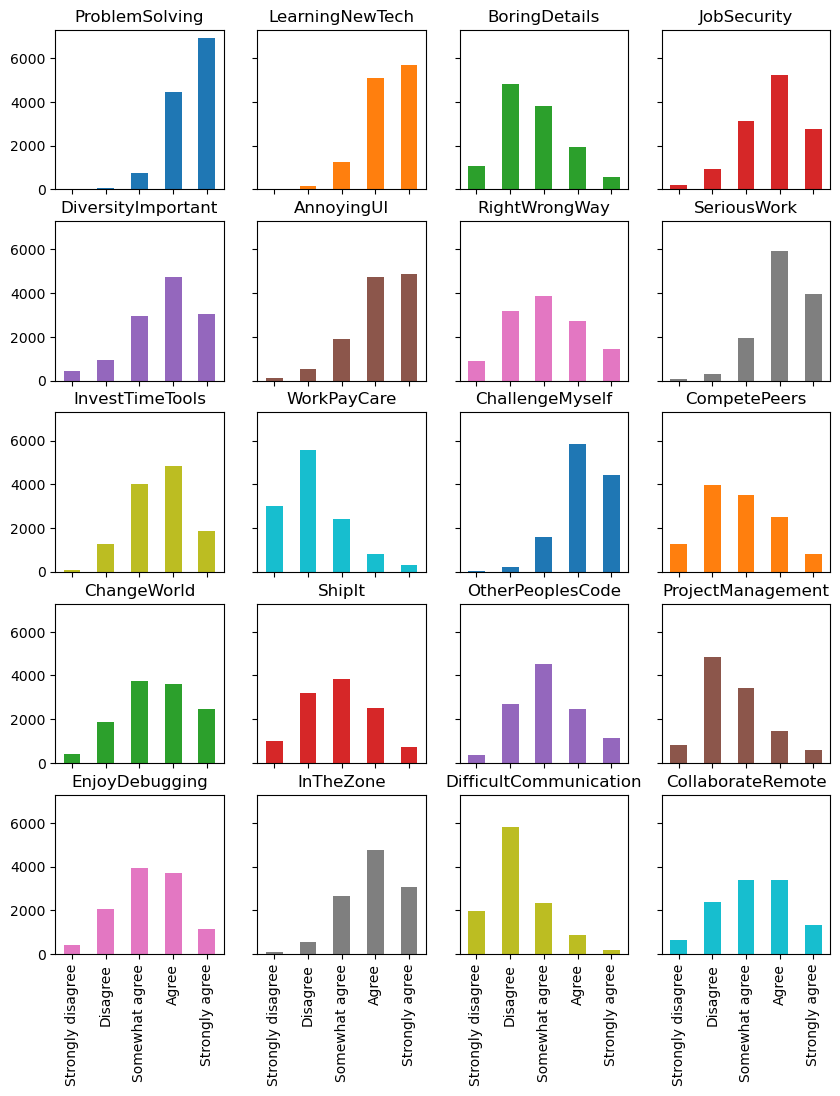

In [5]:
dfplot = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Somewhat agree', 'Agree',
       'Strongly agree'])


for col in df2.columns[4:]:
    counts = df2[col].value_counts()
    dfplot[col] = counts

dfplot.plot(kind="bar", subplots=True, layout=(5,4), legend=False, sharey=True, figsize=(10,12));

# 

Based on these graphs, I will use BoringDetails, DiversityImportant, RightWrongWay, CompetePeers, ChangeWorld, ShipIt, OtherPeoplesCode, ProjectManagement, EnjoyDebugging, and CollaborateRemote as my personality metrics.

In [6]:
df3 = df[['EmploymentStatus', 'Salary', 'JobSatisfaction', 'CareerSatisfaction', 'BoringDetails', 
   'DiversityImportant', 'RightWrongWay', 'CompetePeers', 'ChangeWorld', 
   'ShipIt', 'OtherPeoplesCode', 'ProjectManagement', 'EnjoyDebugging',
   'CollaborateRemote']]


I want to replace EmploymentStatus with a column containing boolean values. 'Employed part-time', 'Employed full-time', and 'Independent contractor, freelancer, or self-employed' will be replaced with 1. 'Not employed, but looking for work' will be replaced with 0. 'Not employed, but looking for work', 'I prefer not to say', and 'Retired' will be replaced with NaN as we are only interested in people who are employed or seeking employment.

In [7]:
new_col = df3['EmploymentStatus'].replace(
['Not employed, and not looking for work', 'Employed part-time',
 'Employed full-time', 'Independent contractor, freelancer, or self-employed',
 'Not employed, but looking for work', 'I prefer not to say', 'Retired'],
[np.nan, 1, 1, 1, 0, np.nan, np.nan])
df3.insert(loc=0, column='Employment', value=new_col)
df3 = df3.drop('EmploymentStatus', axis=1)
print(df3)

       Employment    Salary  JobSatisfaction  CareerSatisfaction  \
0             NaN       NaN              NaN                 NaN   
1             1.0       NaN              NaN                 NaN   
2             1.0  113750.0              9.0                 8.0   
3             1.0       NaN              3.0                 6.0   
4             1.0       NaN              8.0                 6.0   
...           ...       ...              ...                 ...   
19097         1.0       NaN              8.0                 9.0   
19098         NaN       NaN              NaN                 NaN   
19099         1.0       NaN              5.0                 4.0   
19100         1.0  110000.0              9.0                 8.0   
19101         1.0       NaN              8.0                 8.0   

        BoringDetails DiversityImportant   RightWrongWay    CompetePeers  \
0            Disagree              Agree  Somewhat agree        Disagree   
1                 NaN          

Satisfaction will be the average of JobSatisfaction and CareerSatisfaction

In [8]:
new_col = (df3['JobSatisfaction'] + df3['CareerSatisfaction']) / 2
df3.insert(loc=2, column='Satisfaction', value=new_col)
df3 = df3.drop(['JobSatisfaction', 'CareerSatisfaction'], axis=1)


If I wanted to investigate the relationship between success and combinations of personality questions, I could use imputing to replace some of the NaNs with actual numbers so I can use more of the data. For example, when looking at the relationship with salary I could keep any row which has data for salary and for more than half of the personality questions.

In [9]:
df3_copy = df3.copy()

# Record which rows have at least 5 NaNs. Don't remove them yet, as we can use the data
# that is there to help fill out the other rows.
to_drop = df3_copy[df3_copy[df3_copy.columns[3:]].isna().sum(axis = 1) >= 5].index

# Replace text values with numerical ones so we can take the mean
df3_copy.replace(["Strongly disagree", "Disagree", "Somewhat agree", "Agree", "Strongly agree"],
           [-2, -1, 0, 1, 2], inplace=True)

# Replace NaNs with the mean for the column
for col in df3_copy.columns[3:]:
    print(col)
    print(df3_copy[col])
    df3_copy[col].fillna((df3_copy[col].mean()), inplace=True)
    
# Now remove the rows we recorded earlier
df3_copy.drop(to_drop, axis=0, inplace=True)

df3_copy

BoringDetails
0       -1.0
1        NaN
2        0.0
3       -1.0
4        NaN
        ... 
19097    NaN
19098    NaN
19099    NaN
19100    NaN
19101    NaN
Name: BoringDetails, Length: 19102, dtype: float64
DiversityImportant
0        1.0
1        NaN
2        2.0
3        1.0
4        NaN
        ... 
19097    NaN
19098    NaN
19099    NaN
19100    NaN
19101    NaN
Name: DiversityImportant, Length: 19102, dtype: float64
RightWrongWay
0        0.0
1        NaN
2       -1.0
3        0.0
4        NaN
        ... 
19097    NaN
19098    NaN
19099    NaN
19100    NaN
19101    NaN
Name: RightWrongWay, Length: 19102, dtype: float64
CompetePeers
0       -1.0
1        NaN
2       -1.0
3        0.0
4        NaN
        ... 
19097    NaN
19098    NaN
19099    NaN
19100    NaN
19101    NaN
Name: CompetePeers, Length: 19102, dtype: float64
ChangeWorld
0        1.0
1        NaN
2        1.0
3        1.0
4        NaN
        ... 
19097    NaN
19098    NaN
19099    NaN
19100    NaN
19101    NaN
Name:

,Employment,Salary,Satisfaction,BoringDetails,DiversityImportant,RightWrongWay,CompetePeers,ChangeWorld,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,CollaborateRemote
2,1.0,113750.0,8.5,0.0,2.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.0
3,1.0,NaN,4.5,-1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,1.0,NaN,6.0,-2.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,-2.0
14,1.0,100000.0,8.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,0.0
15,1.0,NaN,8.0,-1.0,-2.0,1.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19088,1.0,41250.0,8.0,-1.0,2.0,-1.0,1.0,1.0,-1.0,0.0,1.0,1.0,2.0
19091,1.0,NaN,8.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0
19094,1.0,NaN,NaN,-1.0,2.0,1.0,0.0,0.0,-1.0,1.0,0.0,1.0,1.0
19095,1.0,NaN,8.5,-1.0,1.0,0.0,-1.0,1.0,2.0,0.0,-1.0,1.0,0.0


However, for the purpose of answering the questions I want to answer, I think the best approach is to process the data separately for each combination of success metric and personality metric, and simply remove rows with NaNs in either of these two columns. The following function processes two columns of the data in this way, then plots the average of the first column for each unique value of the second column.

                   RightWrongWay
Strongly disagree   64000.148222
Disagree            65897.087299
Somewhat agree      62824.893937
Agree               49491.096234
Strongly agree      39311.135794


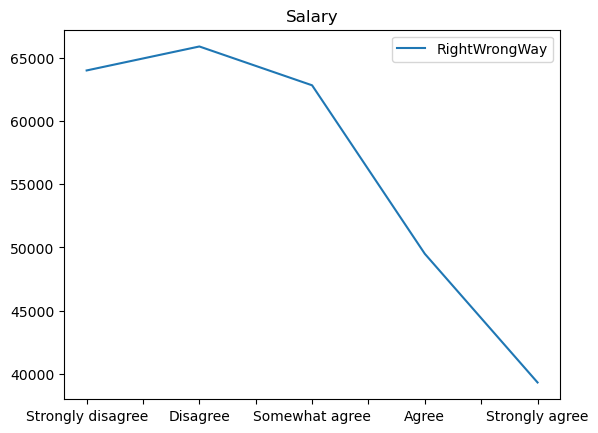

In [10]:
def clean_and_plot_data(df_in, draw_plot=True):
    '''
    INPUT
    df_in - pandas DataFrame with two columns. The first column will be used for
        the graph's y axis and the second column's unique values will be used for the
        graph's x axis
    draw_plot - if true, the function draws a plot of the data as well as returning it. If
        false, the function simply returns the data
    
    OUTPUT
    df_out - a DataFrame containing the values used to plot the graph
    
    This function drops all rows with NaN values, then takes the average of the
    first column's value for each unique value of the second column. The result
    is plotted in a bar chart and also returned.
    '''
    # Drop rows with missing data
    df = df_in.dropna(axis=0, how='any')
    
    # Index the rows to make sure they're in the right order    
    df_out = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Somewhat agree', 'Agree',
       'Strongly agree'])
    
    # Average the first column, grouped by the second    
    df_out[df_in.columns[1]] = df.groupby(df.columns[1]).mean()
    
    # If the flag is set, draw the graph    
    if draw_plot:
        df_out.plot(kind="line", title=df_in.columns[0])
    
    return df_out

print(clean_and_plot_data(df3[['Salary', 'RightWrongWay']]))

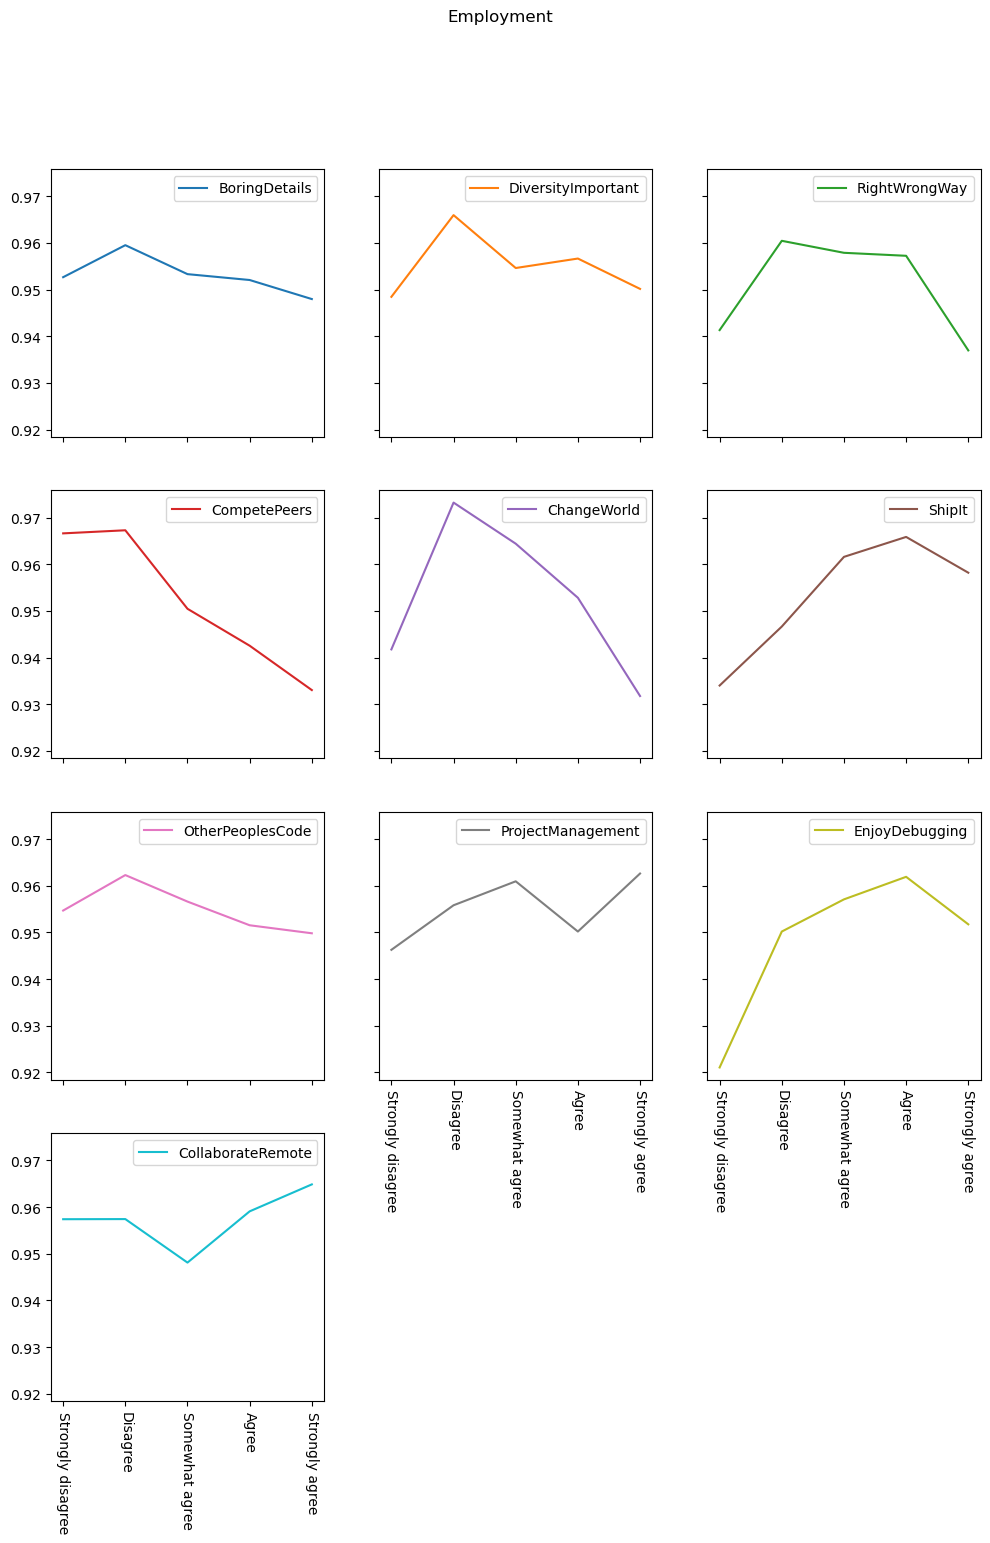

In [11]:
dfplot = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Somewhat agree', 'Agree',
       'Strongly agree'])

for col in df3.columns[3:]:
    dfplot[col] = clean_and_plot_data(df3[['Employment', col]], draw_plot=False)

dfplot.plot(kind="line", subplots=True, layout=(4,3), legend=True, sharey=True, figsize=(12,16), title="Employment", rot=270);


This suggests that there is perhaps a positive correlation with ShipIt and EnjoyDebugging, and a negative correlation with CompetePeers. However, none of the graphs are strictly increasing or decreasing (although CompetePeers comes close), so I don't think we can be confident that any of these factors have a significant effect on employability.

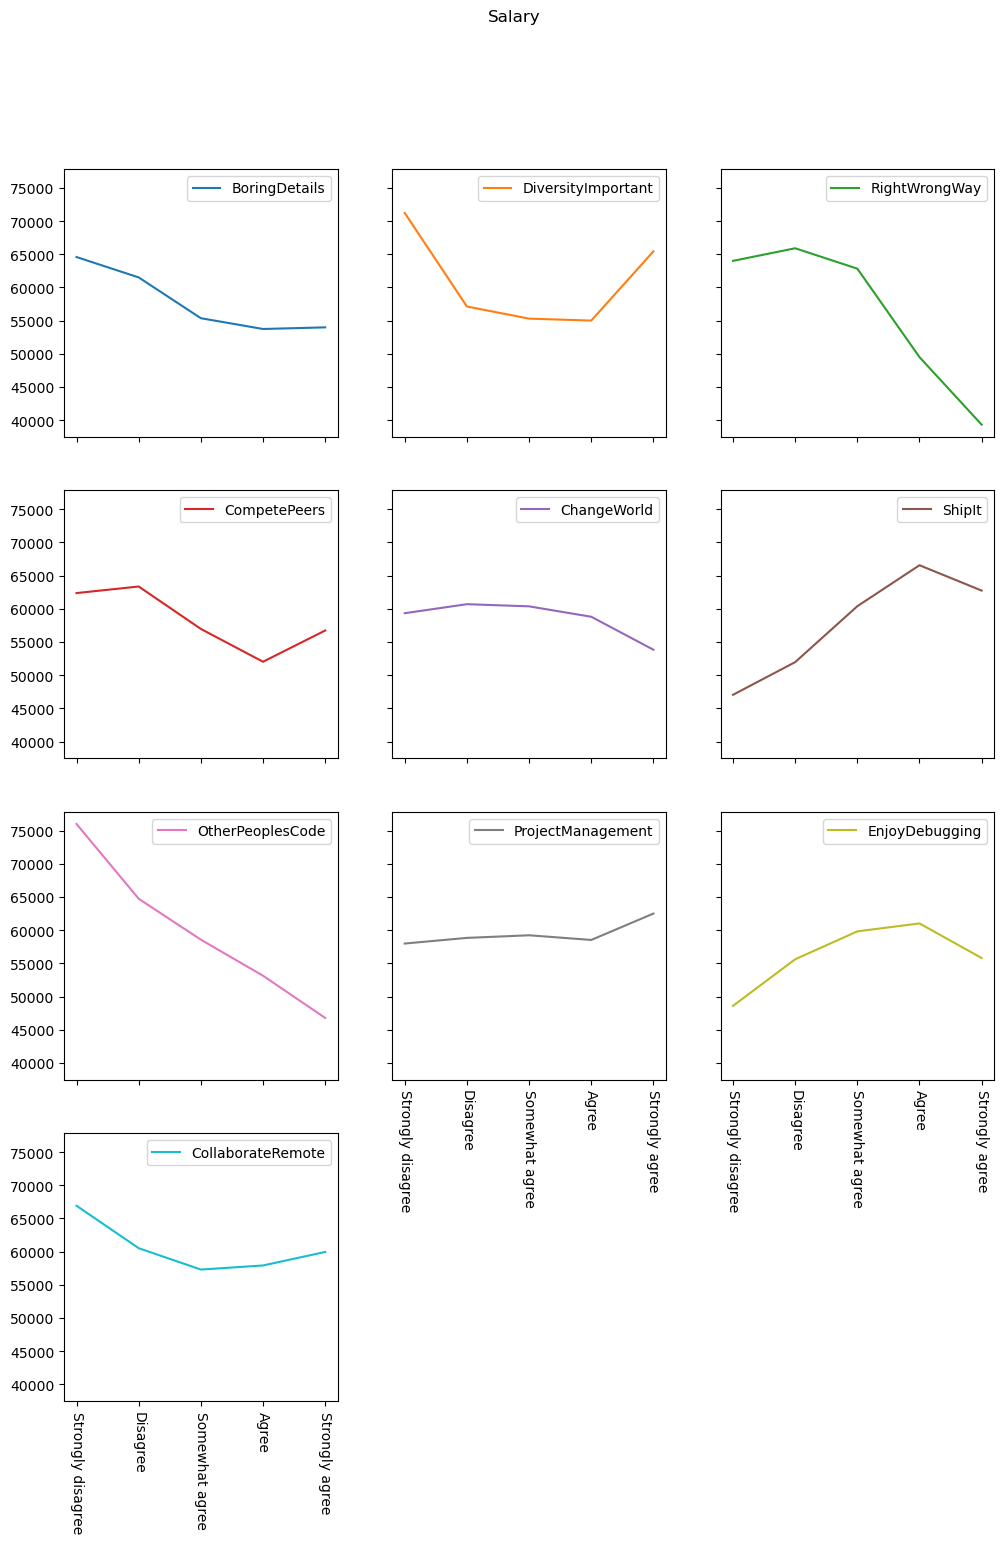

In [12]:
dfplot = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Somewhat agree', 'Agree',
       'Strongly agree'])

for col in df3.columns[3:]:
    dfplot[col] = clean_and_plot_data(df3[['Salary', col]], draw_plot=False)

dfplot.plot(kind="line", subplots=True, layout=(4,3), legend=True, sharey=True, figsize=(12,16), title="Salary", rot=270);


This shows a pretty clear negative correlation with RightWrongWay and OtherPeoplesCode. The data also suggests, although less strongly, a negative correlation with BoringDetails and a positive correlation with ShipIt.

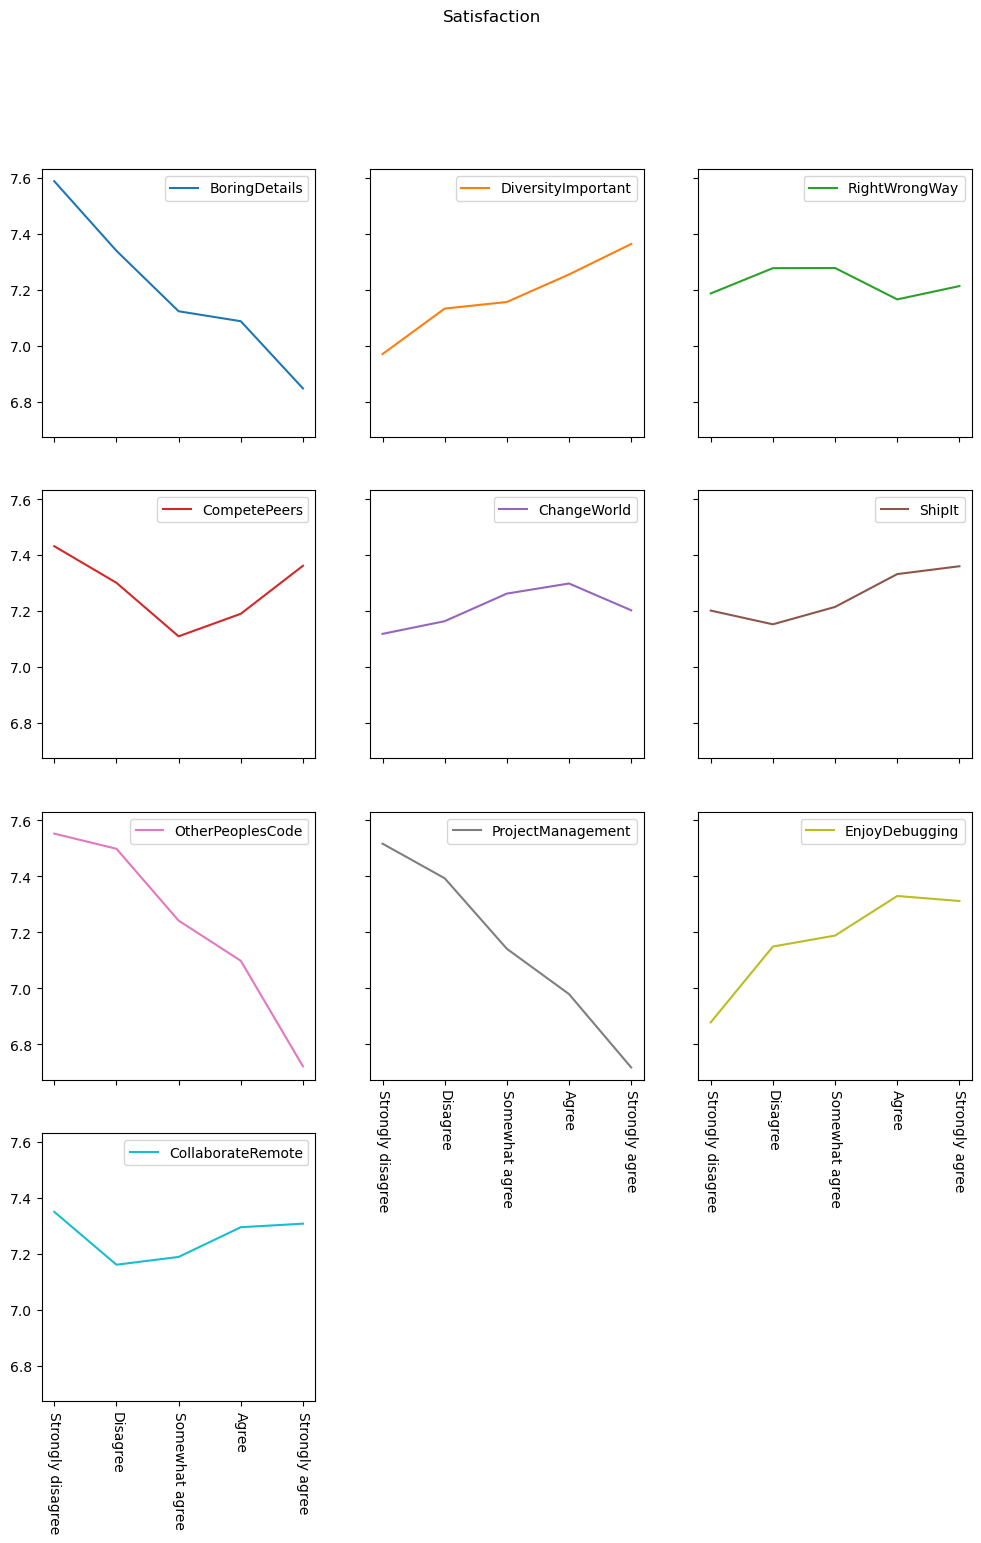

In [13]:
dfplot = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Somewhat agree', 'Agree',
       'Strongly agree'])

for col in df3.columns[3:]:
    dfplot[col] = clean_and_plot_data(df3[['Satisfaction', col]], draw_plot=False)

dfplot.plot(kind="line", subplots=True, layout=(4,3), legend=True, sharey=True, figsize=(12,16), title="Satisfaction", rot=270);


This data shows a pretty clear negative correlation with BoringDetails, OtherPeoplesCode and ProjectManagement, and it also suggests a positive correlation with DiversityImportant and EnjoyDebugging.